# Import Libraries and Data

In [2]:
!pip install quandl 

In [12]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

In [6]:
quandl.ApiConfig.api_key = "mjz_jY9hysLvbBbtyRd1" 

In [273]:
 file_path = "C:\\Users\\hp\\Documents\\WB_DATA_d950d0cd269a601150c0afd03b234ee2.csv"  

df = pd.read_csv(file_path)  

# Display the first few rows  
print(df.head())  

              series_id country_code  \
0  EN.ATM.NOXE.AG.KT.CE          SSA   
1  EN.ATM.NOXE.AG.KT.CE          SSA   
2  EN.ATM.NOXE.AG.KT.CE          SSA   
3  EN.ATM.NOXE.AG.KT.CE          SSA   
4  EN.ATM.NOXE.AG.KT.CE          SSA   

                                 country_name  year          value  
0  Sub-Saharan Africa (excluding high income)  1970  280488.417477  
1  Sub-Saharan Africa (excluding high income)  1971  203873.439003  
2  Sub-Saharan Africa (excluding high income)  1972  210371.610345  
3  Sub-Saharan Africa (excluding high income)  1973  225710.677001  
4  Sub-Saharan Africa (excluding high income)  1974  186188.848701  


In [88]:
print("\nShape of the dataset:", df.shape)  


Shape of the dataset: (9109067, 5)


In [98]:
print(df.columns)


Index(['series_id', 'country_code', 'country_name', 'year', 'value'], dtype='object')


### Subset of Data

In [311]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Create a subset for USA from 1990 to 2020
df_subset = df[(df['country_code'] == 'USA') & (df['year'].between(1990, 2020))].copy()

# Reset the index
df_subset.reset_index(drop=True, inplace=True)

# Convert 'year' to datetime format and set as index
df_subset['year'] = pd.to_datetime(df_subset['year'], format='%Y')
df_subset.set_index('year', inplace=True)

# Check the result
df_subset.head() 

,series_id,country_code,country_name,value
year,,,,
2010-01-01,AG.LND.TOTL.RU.K2,USA,United States,8.549546e+06
2010-01-01,AG.LND.EL5M.RU.ZS,USA,United States,9.803292e-01
2010-01-01,AG.LND.EL5M.RU.K2,USA,United States,9.167646e+04
2010-01-01,EN.POP.EL5M.RU.ZS,USA,United States,2.486133e-01
1997-01-01,NV.AGR.EMPL.KD,USA,United States,3.579540e+04


##### Created a subset of the original dataset for the United States and limited the data to the years 1990 to 2020. This range was selected to:

Focus on recent historical trends that are more relevant to current and future forecasting.

Avoid outdated or less relevant historical events that could bias the analysis.

Ensure we do not include forecasted or projected data, which might appear in more recent years or as part of future planning scenarios.

### Line Chart 

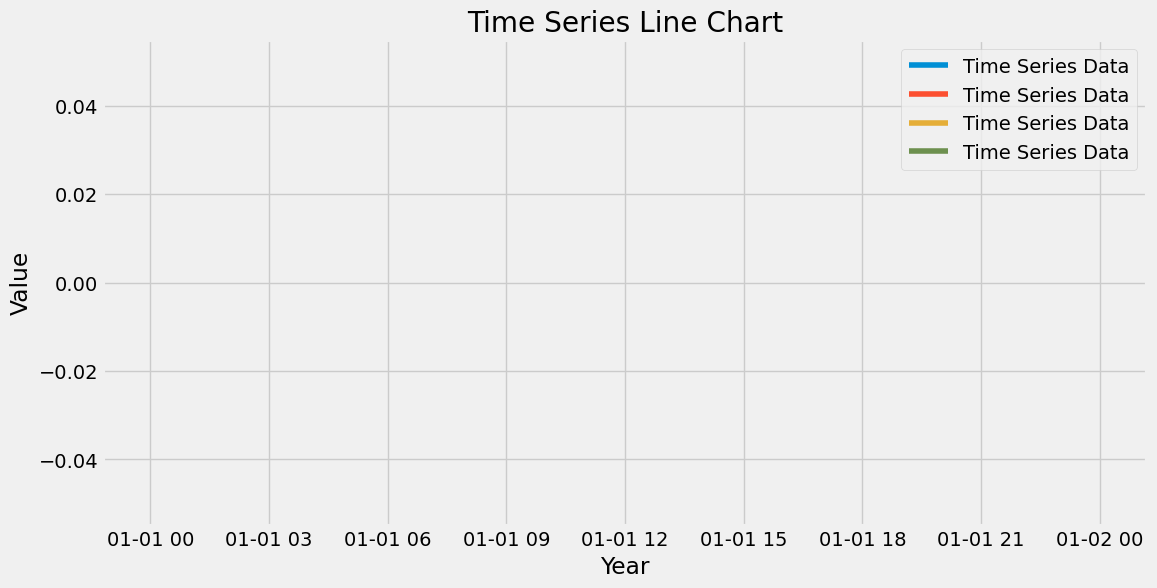

In [104]:
plt.figure(figsize=(12,6))  
plt.plot(df_subset, label="Time Series Data")  
plt.xlabel("Year")  
plt.ylabel("Value")  
plt.title("Time Series Line Chart")  
plt.legend()  
plt.show()  

### Decompose data 

In [307]:
# Make sure we're not working with empty or broken data
df_subset = df_subset.copy()

# Check and convert 'year' to datetime
if 'year' in df_subset.columns:
    df_subset['year'] = pd.to_numeric(df_subset['year'], errors='coerce')
    df_subset.dropna(subset=['year'], inplace=True)
    df_subset['year'] = pd.to_datetime(df_subset['year'], format='%Y')
    df_subset.set_index('year', inplace=True)
else:
    # If 'year' is already index, make sure it's datetime
    df_subset.index = pd.to_datetime(df_subset.index, errors='coerce')

# Drop rows where 'value' is missing
df_subset.dropna(subset=['value'], inplace=True)

# Final check
print("Data points available:", df_subset.shape[0])

# Now decompose
if df_subset.shape[0] >= 2:
    decomposition = seasonal_decompose(df_subset['value'], model='additive', period=1)
    decomposition.plot()
    plt.suptitle('Time Series Decomposition of Emissions Data (USA)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points to perform decomposition.") 

Data points available: 0
Not enough data points to perform decomposition.


## Dickey Test

In [248]:
# Convert to float32 to save memory
df_subset['value'] = df_subset['value'].astype('float32')

df_sample = df_subset['value'].dropna().sample(10000, random_state=42)

# Perform ADF test
result = adfuller(df_sample)

# Print test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -100.00797595464672
p-value: 0.0
Critical Values: {'1%': -3.4310041633725734, '5%': -2.861829101294412, '10%': -2.566923883481157}


#### ## 📊 Dickey-Fuller Test for Stationarity

The **Augmented Dickey-Fuller (ADF) test** is used to determine whether our time series data is **stationary** or not. 

### **🔬 Null Hypothesis (H₀):**
- The data has a **unit root** (i.e., the time series is **non-stationary**).

### **🧪 Test Results:**
- **ADF Statistic:** -100.01
- **p-value:** 0.0
- **Critical Values:**
  - 1%: -3.4310
  - 5%: -2.8618
  - 10%: -2.5669

### **📊 Interpretation:**
1. The **p-value (0.0) is less than 0.05**, so we **reject** the null hypothesis (**H₀**).
2. The **ADF Statistic (-100.01) is much lower** than all critical values (-3.4310, -2.8618, -2.5669), confirming that the data is **stationary**.

### **✅ Conclusion:**
Since the test results indicate stationarity, no further differencing is required. The dataset is ready for time series modeling, such as ARIMA or other forecasting techniques.


### Data’s Autocorrelations.

In [318]:
df_subset['diff_1'] = df_subset['value'].diff()

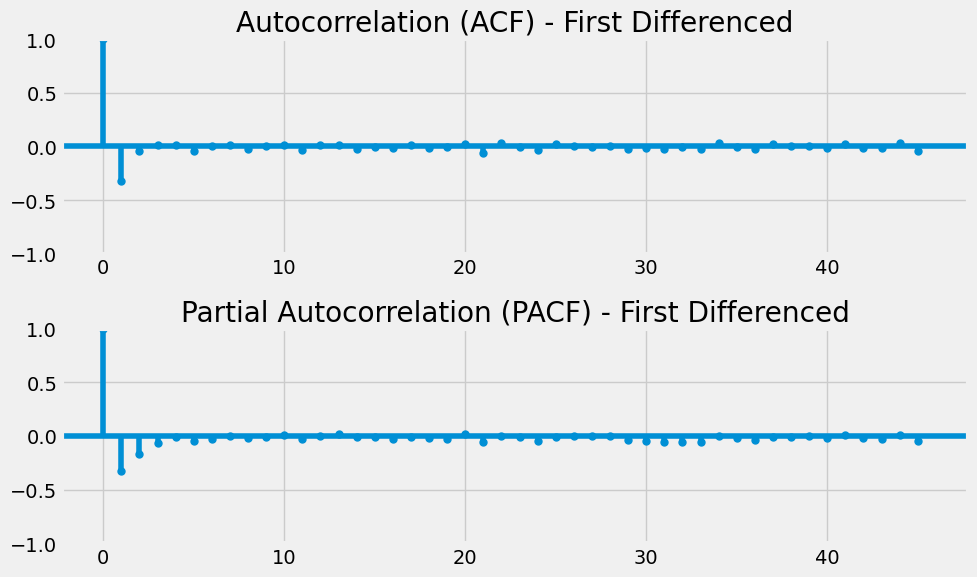

In [320]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))

# ACF and PACF for first-differenced data
plot_acf(df_subset['diff_1'].dropna(), ax=ax[0])
plot_pacf(df_subset['diff_1'].dropna(), ax=ax[1])

ax[0].set_title('Autocorrelation (ACF) - First Differenced')
ax[1].set_title('Partial Autocorrelation (PACF) - First Differenced')

plt.tight_layout()
plt.show() 